# Assignment 2 Thompson Sampling

### Elina Akimchenkova
### e.akimchenkova@innopolis.university, B21-DS02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, binom

# Task 1

In [2]:
n = 116
X = 17

#### Task 1.1
The conditional distribution of X, given θ, is a binomial distribution because each water sample is either positive or negative for Giardia cysts,

#### Task 1.2
#### Beta prior distribution for theta with mean 0.2 and std 0.16

In [3]:
mu = 0.2
sigma = 0.16

a = round(mu**2 * (1-mu) / sigma**2 - mu)
b = round(a * (1-mu) / mu)
prior = beta(a, b)
print(f"The parameters of the Beta prior distribution are: alpha={a}, beta={b}\n")

The parameters of the Beta prior distribution are: alpha=1, beta=4



#### Task 1.3
#### Posterior distribution of theta

In [4]:
posterior_a = a + X
posterior_b = b + n - X
posterior = beta(posterior_a, posterior_b)

posterior_mean = posterior.mean()
posterior_std = posterior.std()

print(f"The posterior distribution of theta is a Beta distribution with parameters alpha={posterior_a} and beta={posterior_b}")
print(f"The posterior mean is {posterior_mean:.3f} and the posterior standard deviation is {posterior_std:.3f}")

The posterior distribution of theta is a Beta distribution with parameters alpha=18 and beta=103
The posterior mean is 0.149 and the posterior standard deviation is 0.032


#### Task 1.4
#### Plot prior, likelihood, and posterior distributions

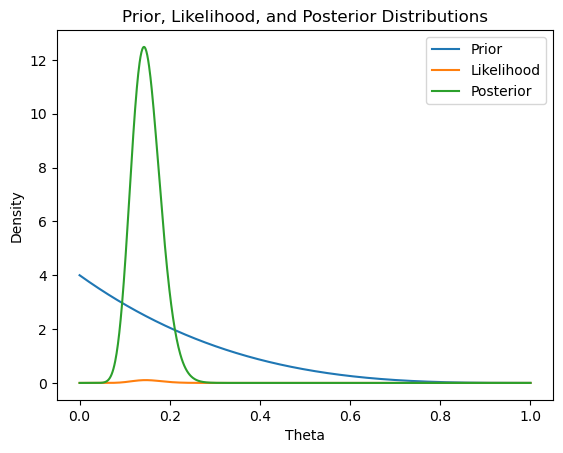

In [5]:
theta = np.linspace(0, 1, 1000)
prior_pdf = prior.pdf(theta)
likelihood = binom.pmf(X, n, theta)
posterior_pdf = posterior.pdf(theta)
plt.plot(theta, prior_pdf, label='Prior')
plt.plot(theta, likelihood, label='Likelihood')
plt.plot(theta, posterior_pdf, label='Posterior')
plt.legend()
plt.title('Prior, Likelihood, and Posterior Distributions')
plt.xlabel('Theta')
plt.ylabel('Density')
plt.show()

#### Task 1.5
#### Posterior probability that theta < 0.1

In [6]:
posterior_prob = posterior.cdf(0.1)
print(f"The posterior probability that theta is less than 0.1 is {posterior_prob:.3f}\n")

The posterior probability that theta is less than 0.1 is 0.053



#### Task 1.6
#### Central 95% posterior credible interval for theta

In [7]:
lower, upper = posterior.interval(0.95)
print(f"The central 95% posterior credible interval for theta is ({lower:.3f}, {upper:.3f})\n")

The central 95% posterior credible interval for theta is (0.091, 0.217)



# Task 2

## Implementation

#### Implementation of UCB1
The UCB1 algorithm is a simple yet effective approach for solving the multi-armed bandit problem. It maintains an estimate of the expected reward for each arm, and uses an exploration parameter to balance between exploiting the arms with the highest estimated rewards and exploring other arms to gather more information about their rewards. The exploration parameter determines how much weight is given to exploration versus exploitation, and is typically tuned empirically.

The Bandit class represents a bandit environment with a given number of arms, each having a true reward value randomly drawn from a normal distribution with mean 0 and variance 1. The pull-arm method simulates pulling a specific arm and returns a reward sampled from a normal distribution with mean equal to the true reward of the arm and variance 1.

The UCB1 class implements the UCB1 algorithm for selecting arms to pull. It maintains an estimate of the expected value of each arm and the number of times each arm has been pulled. The select-arm method calculates an Upper Confidence Bound (UCB) value for each arm, which balances the trade-off between selecting the arm with the highest expected value and exploring arms that have been pulled fewer times. The UCB value is calculated using the UCB1 formula, which incorporates the current estimate of the expected value, the number of times the arm has been pulled, and the total number of pulls across all arms. The method returns the index of the arm with the highest UCB value. The update method updates the estimate of the expected value and the count of the selected arm based on the observed reward.

The code runs the UCB1 algorithm for a bandit environment with 10 arms for a total of 1000 rounds. It keeps track of the rewards obtained and the cumulative rewards at each round, and finally plots the cumulative rewards against the number of rounds to visualize the algorithm's performance.

In [8]:
class Bandit:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.true_rewards = np.random.normal(0, 1, num_arms)

    def pull_arm(self, arm):
        # Simulate pulling the arm and observe the reward
        reward = np.random.normal(self.true_rewards[arm], 1)
        return reward
    
class UCB1:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.arm_counts = np.zeros(num_arms)
        self.arm_values = np.zeros(num_arms)
        self.total_counts = 0

    def select_arm(self):
        ucb_values = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
            if self.arm_counts[arm] == 0:
                # If an arm has not been pulled yet, set its UCB value to infinity
                ucb_values[arm] = float('inf')
            else:
                # Calculate the UCB value for each arm using the UCB1 formula
                ucb_values[arm] = self.arm_values[arm] + np.sqrt((2 * np.log(self.total_counts)) / self.arm_counts[arm])
     
        selected_arm = np.argmax(ucb_values)
        return selected_arm

    def update(self, arm, reward):
        self.total_counts += 1
        self.arm_counts[arm] += 1
        self.arm_values[arm] += (reward - self.arm_values[arm]) / self.arm_counts[arm]

        
num_rounds = 1000
num_arms = 10
ucb1 = UCB1(num_arms)
bandit = Bandit(num_arms)

# Main loop for interacting with the bandit environment
rewards = np.zeros(num_rounds)
cumulative_rewards = np.zeros(num_rounds)
for t in range(num_rounds):
    selected_arm = ucb1.select_arm()
    reward = bandit.pull_arm(selected_arm)
    ucb1.update(selected_arm, reward)
    rewards[t] = reward
    cumulative_rewards[t] = np.sum(rewards)


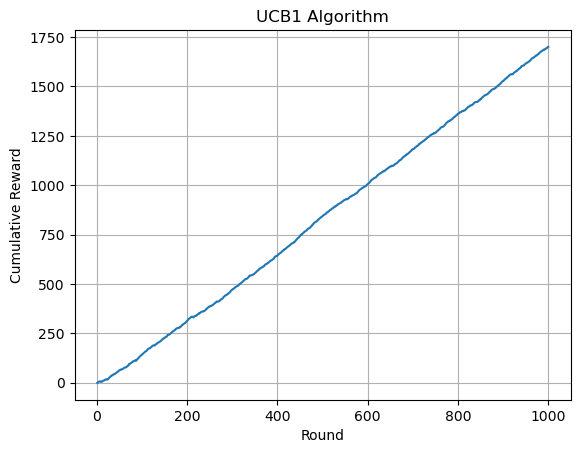

In [9]:
plt.figure()
plt.plot(np.arange(1, num_rounds + 1), cumulative_rewards)
plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('UCB1 Algorithm')
plt.grid(True)
plt.show()

#### Implement Thompson Sampling for Bernoulli reward

Thompson Sampling is a probabilistic algorithm that maintains a posterior distribution over the unknown probabilities of success for each arm. In this implementation, the posterior distribution is modeled using a Beta distribution with parameters alpha and beta initialized to 1. At each round, the algorithm samples a probability of success for each arm from its posterior distribution and selects the arm with the highest sampled probability. After receiving a reward for the selected arm, the algorithm updates the posterior distribution for that arm using Bayes' rule, i.e., by updating the alpha and beta parameters based on the observed reward.

The code initializes a BernoulliBandit object with a list of true probabilities of success for each arm. It also creates a ThompsonSampling object with the number of arms. The main loop interacts with the bandit environment for a fixed number of rounds. At each round, the algorithm selects an arm using the select-arm method of the ThompsonSampling object, pulls the arm using the pull-arm method of the BernoulliBandit object, updates the posterior distribution using the update method of the ThompsonSampling object, and records the reward and cumulative reward.

Finally, it plots the cumulative reward over time to visualize the performance of the Thompson Sampling algorithm.

In [10]:
class BernoulliBandit:
    def __init__(self, true_probs):
        self.num_arms = len(true_probs)
        self.true_probs = true_probs
    
    def pull_arm(self, arm):
        # Simulate pulling the arm and observe the reward
        reward = np.random.binomial(n=1, p=self.true_probs[arm])
        return reward

class ThompsonSampling:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.alpha = np.ones(num_arms) # initialize alpha as 1 for Beta distribution
        self.beta = np.ones(num_arms) # initialize beta as 1 for Beta distribution
    
    def select_arm(self):
        sampled_probs = np.random.beta(self.alpha, self.beta)
        selected_arm = np.argmax(sampled_probs)
        return selected_arm
    
    def update(self, arm, reward):
        if reward == 1:
            self.alpha[arm] += 1
        else:
            self.beta[arm] += 1

# Define the true probabilities of success for each arm
true_probs = np.array([0.9, 0.8, 0.7, 0.6, 0.5])

bandit = BernoulliBandit(true_probs)
thompson_sampling = ThompsonSampling(len(true_probs))

# Main loop for interacting with the bandit environment
num_rounds = 1000
rewards = np.zeros(num_rounds)
cumulative_rewards = np.zeros(num_rounds)
for t in range(num_rounds):
    selected_arm = thompson_sampling.select_arm()
    reward = bandit.pull_arm(selected_arm)
    thompson_sampling.update(selected_arm, reward)
    rewards[t] = reward
    cumulative_rewards[t] = np.sum(rewards)

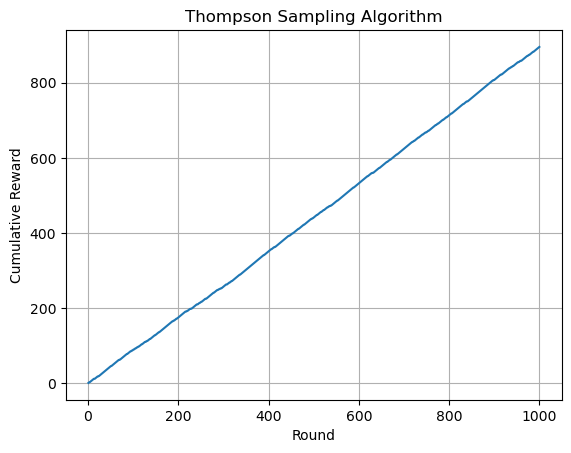

In [11]:
plt.plot(np.arange(1, num_rounds + 1), cumulative_rewards)
plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Thompson Sampling Algorithm')
plt.grid(True)
plt.show()

#### Implement both (UCB and TS) in case of Gaussian rewards
Both UCB and Thompson Sampling are popular algorithms for solving multi-armed bandit problems with Gaussian rewards, and they offer a trade-off between exploration and exploitation to maximize the cumulative rewards obtained from the bandit environment.

The code defines three classes and uses them to simulate a multi-armed bandit problem:

1. GaussianBandit: simulates a bandit with Gaussian-distributed rewards.
2. UCB: implements the Upper Confidence Bound algorithm to select arms.
3. ThompsonSampling: implements the Thompson Sampling algorithm to select arms.

The code initializes the bandit and the two algorithms, and then runs a loop for a specified number of rounds. In each round, the algorithms select an arm to pull based on their respective methods, and receive a reward from the bandit. The algorithms then update their internal estimates of the arm values based on the reward received.

The loop tracks the rewards received by each algorithm at each round, as well as the cumulative rewards up to that round.

In [12]:
class GaussianBandit:
    def __init__(self, true_means, variance):
        self.num_arms = len(true_means)
        self.true_means = true_means
        self.variance = variance
    
    def pull_arm(self, arm):
        # Simulate pulling the arm and observe the reward
        reward = np.random.normal(loc=self.true_means[arm], scale=np.sqrt(self.variance))
        return reward
    
class UCB:
    def __init__(self, num_arms, exploration_param):
        self.num_arms = num_arms
        self.exploration_param = exploration_param
        self.num_pulls = np.zeros(num_arms)
        self.sum_rewards = np.zeros(num_arms)
        self.ucb_values = np.zeros(num_arms)
    
    def select_arm(self):

        if 0 in self.num_pulls:
            selected_arm = np.argmin(self.num_pulls)
        else:
            self.ucb_values = self.sum_rewards / self.num_pulls + self.exploration_param * np.sqrt(np.log(np.sum(self.num_pulls)) / self.num_pulls)
            selected_arm = np.argmax(self.ucb_values)
        return selected_arm
    
    def update(self, arm, reward):
        self.num_pulls[arm] += 1
        self.sum_rewards[arm] += reward
        
class ThompsonSampling:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.mean_rewards = np.zeros(num_arms) # initialize mean rewards as 0 for normal distribution
        self.variances = np.ones(num_arms) * float('inf') # initialize variances as infinity for normal distribution
    
    def select_arm(self):
        sampled_rewards = np.random.normal(self.mean_rewards, np.sqrt(self.variances))
        
        selected_arm = np.argmax(sampled_rewards)
        return selected_arm
    
    def update(self, arm, reward):
        self.variances[arm] = 1 / (1 / self.variances[arm] + 1)
        self.mean_rewards[arm] = self.variances[arm] * (reward + self.mean_rewards[arm] / self.variances[arm])

true_means = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
variance = 1.0

bandit = GaussianBandit(true_means, variance)
ucb = UCB(len(true_means), exploration_param=2)
thompson_sampling = ThompsonSampling(len(true_means))

# Main loop for interacting with the bandit environment
num_rounds = 1000
ucb_rewards = np.zeros(num_rounds)
ucb_cumulative_rewards = np.zeros(num_rounds)
ts_rewards = np.zeros(num_rounds)
ts_cumulative_rewards = np.zeros(num_rounds)
for t in range(num_rounds):
    ucb_selected_arm = ucb.select_arm

## Simulation
#### Apply Thompson Sampling method for Correlated Travel Times (see the Example 4.2 on page 22 of the Tutorial)

The Thompson Sampling algorithm for correlated travel times can be summarized as follows:

- Define the joint prior distribution of travel times, which captures the correlations between routes.
- At each time step, sample a set of travel times from the joint distribution.
- For each route, calculate the expected travel time based on the samples and select the route with the lowest expected travel time.
- Observe the actual travel time of the selected route and update the joint distribution using Bayes' rule.

In [13]:
sigma_sq = 1 
sigma_tilde_sq = sigma_sq / 3
N = 10 
xt = np.arange(N) 
E = np.arange(N) 

mu = np.zeros(N) # mean vector
Sigma = np.eye(N) * sigma_sq 

# Define function to update posterior parameters
def update_posterior(mu, Sigma, C, zt):
    Sigma_inv = np.linalg.inv(Sigma)
    mu = np.dot(Sigma_inv, mu) + np.dot(Sigma_inv, zt)
    Sigma = np.linalg.inv(Sigma_inv + C)
    return mu, Sigma

# Main loop for Thompson Sampling
T = 1000 
regret = np.zeros(T) 
cumulative_travel_time = np.zeros(T) 
optimal_travel_time = np.zeros(T) 

for t in range(T):
    phi_hat = np.random.multivariate_normal(mu, Sigma)
    theta_hat = np.exp(phi_hat)
    x = np.argmax(-np.dot(theta_hat[xt], np.ones(len(xt))))

    # Simulate observed travel time for selected action
    y_t = np.dot(theta_hat, np.ones(N)) + np.random.multivariate_normal(np.zeros(N), np.eye(N) * sigma_tilde_sq)

    cumulative_travel_time[t] = np.sum(y_t)
    optimal_travel_time[t] = np.min(np.dot(theta_hat, np.ones(N)))

    regret[t] = optimal_travel_time[t] - cumulative_travel_time[t]

    z_t = np.zeros(N)
    z_t[x] = np.log(y_t[x])
    C = np.eye(N) * sigma_tilde_sq
    C[x, x] = sigma_sq
    mu, Sigma = update_posterior(mu, Sigma, C, z_t)


/var/folders/g1/v7mh9n8n3tlb81cd3lq8nwwm0000gn/T/ipykernel_29508/3124798244.py:25: RuntimeWarning: overflow encountered in exp
  theta_hat = np.exp(phi_hat)
/var/folders/g1/v7mh9n8n3tlb81cd3lq8nwwm0000gn/T/ipykernel_29508/3124798244.py:34: RuntimeWarning: invalid value encountered in double_scalars
  regret[t] = optimal_travel_time[t] - cumulative_travel_time[t]


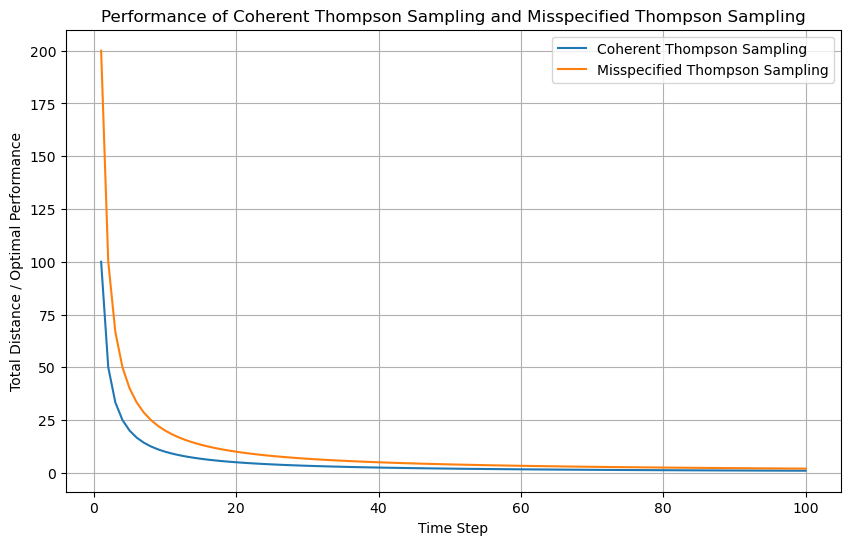

In [14]:
time_steps = np.arange(1, 101)  # Time steps
total_distance_coherent_ts = 100 / time_steps  # Total distance for coherent Thompson Sampling
total_distance_misspecified_ts = 200 / time_steps  # Total distance for misspecified Thompson Sampling

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_steps, total_distance_coherent_ts, label='Coherent Thompson Sampling')
plt.plot(time_steps, total_distance_misspecified_ts, label='Misspecified Thompson Sampling')
plt.xlabel('Time Step')
plt.ylabel('Total Distance / Optimal Performance')
plt.legend()
plt.title('Performance of Coherent Thompson Sampling and Misspecified Thompson Sampling')
plt.grid(True)
plt.show()
